<a href="https://colab.research.google.com/github/parvathysarat/kg-qa/blob/master/transg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download ComplexWebQuestionsSP data

In [0]:
import numpy as np
from numpy import linalg as la
from sklearn import preprocessing
import math
import random
import time
import matplotlib.pyplot as plt


class TransG:
    dim, n_cluster, epos, step_before = 0, 0, 0, 0
    alpha, threshold, CRP= 0.0, 0.0, 0.0
    be_weight_normalized = True
    dir = ""
    entity, rel_clusters, weights_clusters = {}, {}, {}
    head_entity, tail_entity = [], []
    train_triples, test_triples, dev_triples = [], [], []
    relation_tph, relation_hpt = {}, {}
    result = []

    def __init__(self, datadir, dim, alpha, threshold, ncluster, CRP_factor, weight_norm = True, step_before = 10):
        train_dir = datadir + "kb.txt"
        rel_cnt = {}
        self.dir = datadir
        self.dim = dim
        self.alpha = alpha
        self.threshold = threshold
        self.n_cluster = ncluster
        self.be_weight_normalized = weight_norm
        self.step_before = step_before
        with open(train_dir) as file:
            lines = file.readlines()
            for line in lines:
                # print(line)
                [head, rel, tail] = line.strip().split("|")
                if head not in self.entity:
                    self.entity[head] = np.empty([1, dim], dtype=float)
                    self.head_entity.append(head)
                if tail not in self.entity:
                    self.entity[tail] = np.empty([1, dim], dtype=float)
                    self.tail_entity.append(tail)
                if rel not in self.rel_clusters:
                    self.rel_clusters[rel] = {}
                    self.weights_clusters[rel] = np.zeros([1, 20], dtype=float)
                    for i in range(0, ncluster):
                        self.rel_clusters[rel][i] = np.empty([1, dim], dtype=float)
                        self.weights_clusters[rel][0, i] = 1.0 / ncluster
                    rel_cnt[rel] = {"head": [], "tail": [], "total": 0.0}
                self.train_triples.append([head, rel, tail])
                if head not in rel_cnt[rel]["head"]:
                    rel_cnt[rel]["head"].append(head)
                if tail not in rel_cnt[rel]["tail"]:
                    rel_cnt[rel]["tail"].append(tail)
                rel_cnt[rel]["total"] += 1
        for enitiy in self.entity:
            for elem in range(0, dim):
                self.entity[enitiy][0, elem] = random.random()
        for rel in self.rel_clusters:
            for cluster in self.rel_clusters[rel]:
                for elem in range(0, dim):
                    self.rel_clusters[rel][cluster][0, elem] = (2 * random.random() - 1) * math.sqrt(6.0 / dim)
        for rel in rel_cnt:
            self.relation_tph[rel] = rel_cnt[rel]["total"] / len(rel_cnt[rel]["head"])
            self.relation_hpt[rel] = rel_cnt[rel]["total"] / len(rel_cnt[rel]["tail"])
        self.CRP = CRP_factor / len(self.train_triples) * len(rel_cnt)
        self.result.append(["dim:" + str(dim), "alpha:" + str(alpha), "threshold:" + str(threshold),
                            "n_cluster:" + str(ncluster), "CRP_factor" + str(CRP_factor)])
        print("Ready")

    def load_testing(self):
        with open(self.dir + "test.txt") as file:
            lines = file.readlines()
            for line in lines:
                self.test_triples.append(line.strip().split("\t"))

    def load_dev(self):
        with open(self.dir + "dev.txt") as file:
            lines = file.readlines()
            for line in lines:
                self.dev_triples.append(line.strip().split("\t"))

    def sample_false_triple(self, triple):
        [head, rel, tail] = triple
        prob = self.relation_hpt[rel] / (self.relation_hpt[rel] + self.relation_tph[rel])
        while 1:
            if random.random() < prob:
                tail = random.choice(self.tail_entity)
            else:
                head = random.choice(self.head_entity)
            triple_f = [head, rel, tail]
            if triple_f not in self.train_triples:
                return triple_f

    def prob_triples(self, triple):
        mixed_prob = 1e-100
        [head, rel, tail] = triple
        for c in range(0, len(self.rel_clusters[rel])):
            error_c = self.entity[head] + self.rel_clusters[rel][c] - self.entity[tail]
            mixed_prob = max(mixed_prob, math.fabs(self.weights_clusters[rel][0, c]) * math.exp(-np.sum(np.abs(error_c))))
        return mixed_prob

    def training_prob_triples(self, triple):
        mixed_prob = 1e-100
        [head, rel, tail] = triple
        for c in range(0, len(self.rel_clusters[rel])):
            error_c = self.entity[head] + self.rel_clusters[rel][c] - self.entity[tail]
            mixed_prob += math.fabs(self.weights_clusters[rel][0, c]) * math.exp(-np.sum(np.abs(error_c)))
        return mixed_prob

    def train_cluster_once(self, triple, triple_f, cluster, prob_true, prob_false, factor):
        [head, rel, tail] = triple
        [head_f, rel_f, tail_f] = triple_f
        prob_local_true = math.exp(-np.sum(np.abs(self.entity[head] + self.rel_clusters[rel][cluster] -
                                                  self.entity[tail])))
        prob_local_false = math.exp(-np.sum(np.abs(self.entity[head_f] + self.rel_clusters[rel_f][cluster] -
                                                   self.entity[tail_f])))
        self.weights_clusters[rel][0, cluster] += \
            factor / prob_true * prob_local_true * np.sign(self.weights_clusters[rel][0, cluster])
        self.weights_clusters[rel_f][0, cluster] -= \
            factor / prob_false * prob_local_false * np.sign(self.weights_clusters[rel_f][0, cluster])
        change = factor * prob_local_true / prob_true * math.fabs(self.weights_clusters[rel][0, cluster])
        change_f = factor * prob_local_false / prob_false * math.fabs(self.weights_clusters[rel_f][0, cluster])
        self.entity[head] -= change * np.sign(self.entity[head] + self.rel_clusters[rel][cluster] - self.entity[tail])
        self.entity[tail] += change * np.sign(self.entity[head] + self.rel_clusters[rel][cluster] - self.entity[tail])
        self.rel_clusters[rel][cluster] -= change * np.sign(self.entity[head] + self.rel_clusters[rel][cluster] -
                                                            self.entity[tail])
        self.entity[head_f] += change_f * np.sign(self.entity[head_f] + self.rel_clusters[rel_f][cluster] -
                                                  self.entity[tail_f])
        self.entity[tail_f] -= change_f * np.sign(self.entity[head_f] + self.rel_clusters[rel_f][cluster] -
                                                  self.entity[tail_f])
        self.rel_clusters[rel_f][cluster] += change_f * np.sign(self.entity[head_f] +
                                                                self.rel_clusters[rel_f][cluster] - self.entity[tail_f])
        # print la.norm(self.rel_clusters[rel][cluster])
        if la.norm(self.rel_clusters[rel][cluster]) > 1.0:
            self.rel_clusters[rel][cluster] = preprocessing.normalize(self.rel_clusters[rel][cluster], norm='l2')
        if la.norm(self.rel_clusters[rel_f][cluster]) > 1.0:
            self.rel_clusters[rel_f][cluster] = preprocessing.normalize(self.rel_clusters[rel_f][cluster])

    def train_triplet(self, triple):
        [head, rel, tail] = triple
        triple_f = self.sample_false_triple(triple)
        [head_f, rel_f, tail_f] = triple_f
        prob_true = self.training_prob_triples(triple)
        prob_false = self.training_prob_triples(triple_f)
        if prob_true / prob_false > math.exp(self.threshold):
            return
        for c in range(0, len(self.rel_clusters[rel])):
            self.train_cluster_once(triple, triple_f, c, prob_true, prob_false, self.alpha)
        prob_new_component = self.CRP * math.exp(-np.sum(np.abs(self.entity[head] - self.entity[tail])))
        if random.random() < prob_new_component / (prob_new_component + prob_true) and len(self.rel_clusters[rel]) < 20 and self.epos >= self.step_before:
            component = len(self.rel_clusters[rel])
            self.weights_clusters[rel][0, component] = self.CRP
            self.rel_clusters[rel][component] = np.empty([1, self.dim], dtype=float)
            for elem in range(0, self.dim):
                self.rel_clusters[rel][component][0, elem] = (2 * random.random() - 1) * math.sqrt(6.0 / self.dim)
        if la.norm(self.entity[head]) > 1.0:
            self.entity[head] = preprocessing.normalize(self.entity[head])
        if la.norm(self.entity[tail]) > 1.0:
            self.entity[tail] = preprocessing.normalize(self.entity[tail])
        if la.norm(self.entity[head_f]) > 1.0:
            self.entity[head_f] = preprocessing.normalize(self.entity[head_f])
        if la.norm(self.entity[tail_f]) > 1.0:
            self.entity[tail_f] = preprocessing.normalize(self.entity[tail_f])
        if self.be_weight_normalized:
            self.weights_clusters[rel] = preprocessing.normalize(self.weights_clusters[rel])

    def train(self, total_epos):
        print("Progress:")
        while total_epos != self.epos:
            self.epos += 1
            if self.epos % (0.01 * total_epos) == 0:
                print(str(self.epos / (0.01 * total_epos)) + "%")
            for item in self.train_triples:
                self.train_triplet(item)

    def test(self, hit_rank):
        hits = 0.0
        self.load_testing()
        print("testing:")
        for [head, rel, tail] in self.test_triples:
            mean = 0
            if head not in self.head_entity or tail not in self.tail_entity:
                self.result.append([head, rel, tail, '1'])
            else:
                score = self.prob_triples([head, rel, tail])
                for r in self.rel_clusters:
                    if score >= self.prob_triples([head, r, tail]):
                        continue
                    mean += 1
                if mean < hit_rank:
                    hits += 1
                    self.result.append([head, rel, tail, '0'])
                else:
                    self.result.append([head, rel, tail, '1'])
        total = len(self.test_triples)
        accu = hits / total
        self.result.append(["accu:" + str(accu)])
        writefile = open(self.dir + "result.txt", 'w')
        for info in self.result:
            for item in info:
                writefile.write(item + "\t")
            writefile.write("\n")

    def save(self, dir=""):
        if dir == "":
            dir = self.dir
        writeentity = open(dir + "entity.txt", 'w')
        for entity in self.entity:
            writeentity.write(entity + "\t")
            for elem in range(0, self.dim):
                writeentity.write(str(self.entity[entity][0, elem]) + "\t")
            writeentity.write("\n")
        writeentity.close()
        writeweight = open(dir + "weight.txt", 'w')
        for rel in self.rel_clusters:
            writerelation = open(dir + "relation_" + rel + ".txt", 'w')
            writeweight.write(rel + "\t")
            for cluster in self.rel_clusters[rel]:
                writerelation.write(str(cluster) + "\t")
                writeweight.write(str(self.weights_clusters[rel][0, cluster]) + "\t")
                for elem in range(0, self.dim):
                    writerelation.write(str(self.rel_clusters[rel][cluster][0, elem]) + "\t")
                writerelation.write("\n")
            writeweight.write("\n")
            writerelation.close()
        writeweight.close()

    def draw(self, r, dir=""):
        x_good, y_good = [], []
        x_neu, y_neu = [], []
        x_bad, y_bad= [], []
        if dir == "":
            dir = self.dir
        savepath = dir + "map.png"
        for triple in self.train_triples:
            [head, rel, tail] = triple
            if rel == "_good":
                x_good.append(r * (self.entity[tail][0, 0] - self.entity[head][0, 0]))
                y_good.append(r * (self.entity[tail][0, 1] - self.entity[head][0, 1]))
            elif rel == "_bad":
                x_neu.append(r * (self.entity[tail][0, 0] - self.entity[head][0, 0]))
                y_neu.append(r * (self.entity[tail][0, 1] - self.entity[head][0, 1]))
            else:
                x_bad.append(r * (self.entity[tail][0, 0] - self.entity[head][0, 0]))
                y_bad.append(r * (self.entity[tail][0, 1] - self.entity[head][0, 1]))
        plt.clf()
        plt.figure(dpi=1000)
        plt.scatter(x_good, y_good, s = 0.01, color='r', marker='x')
        plt.scatter(x_bad, y_bad, s = 0.01, color='b', marker='x')
        plt.scatter(x_neu, y_neu, s = 0.01, color='tab:gray', marker='x')
        plt.xlim(-500, 500)
        plt.ylim(-500, 500)
        plt.axis('off')
        plt.savefig(savepath)

Ready
Progress:
661.5017554759979
OK


<Figure size 432x288 with 0 Axes>

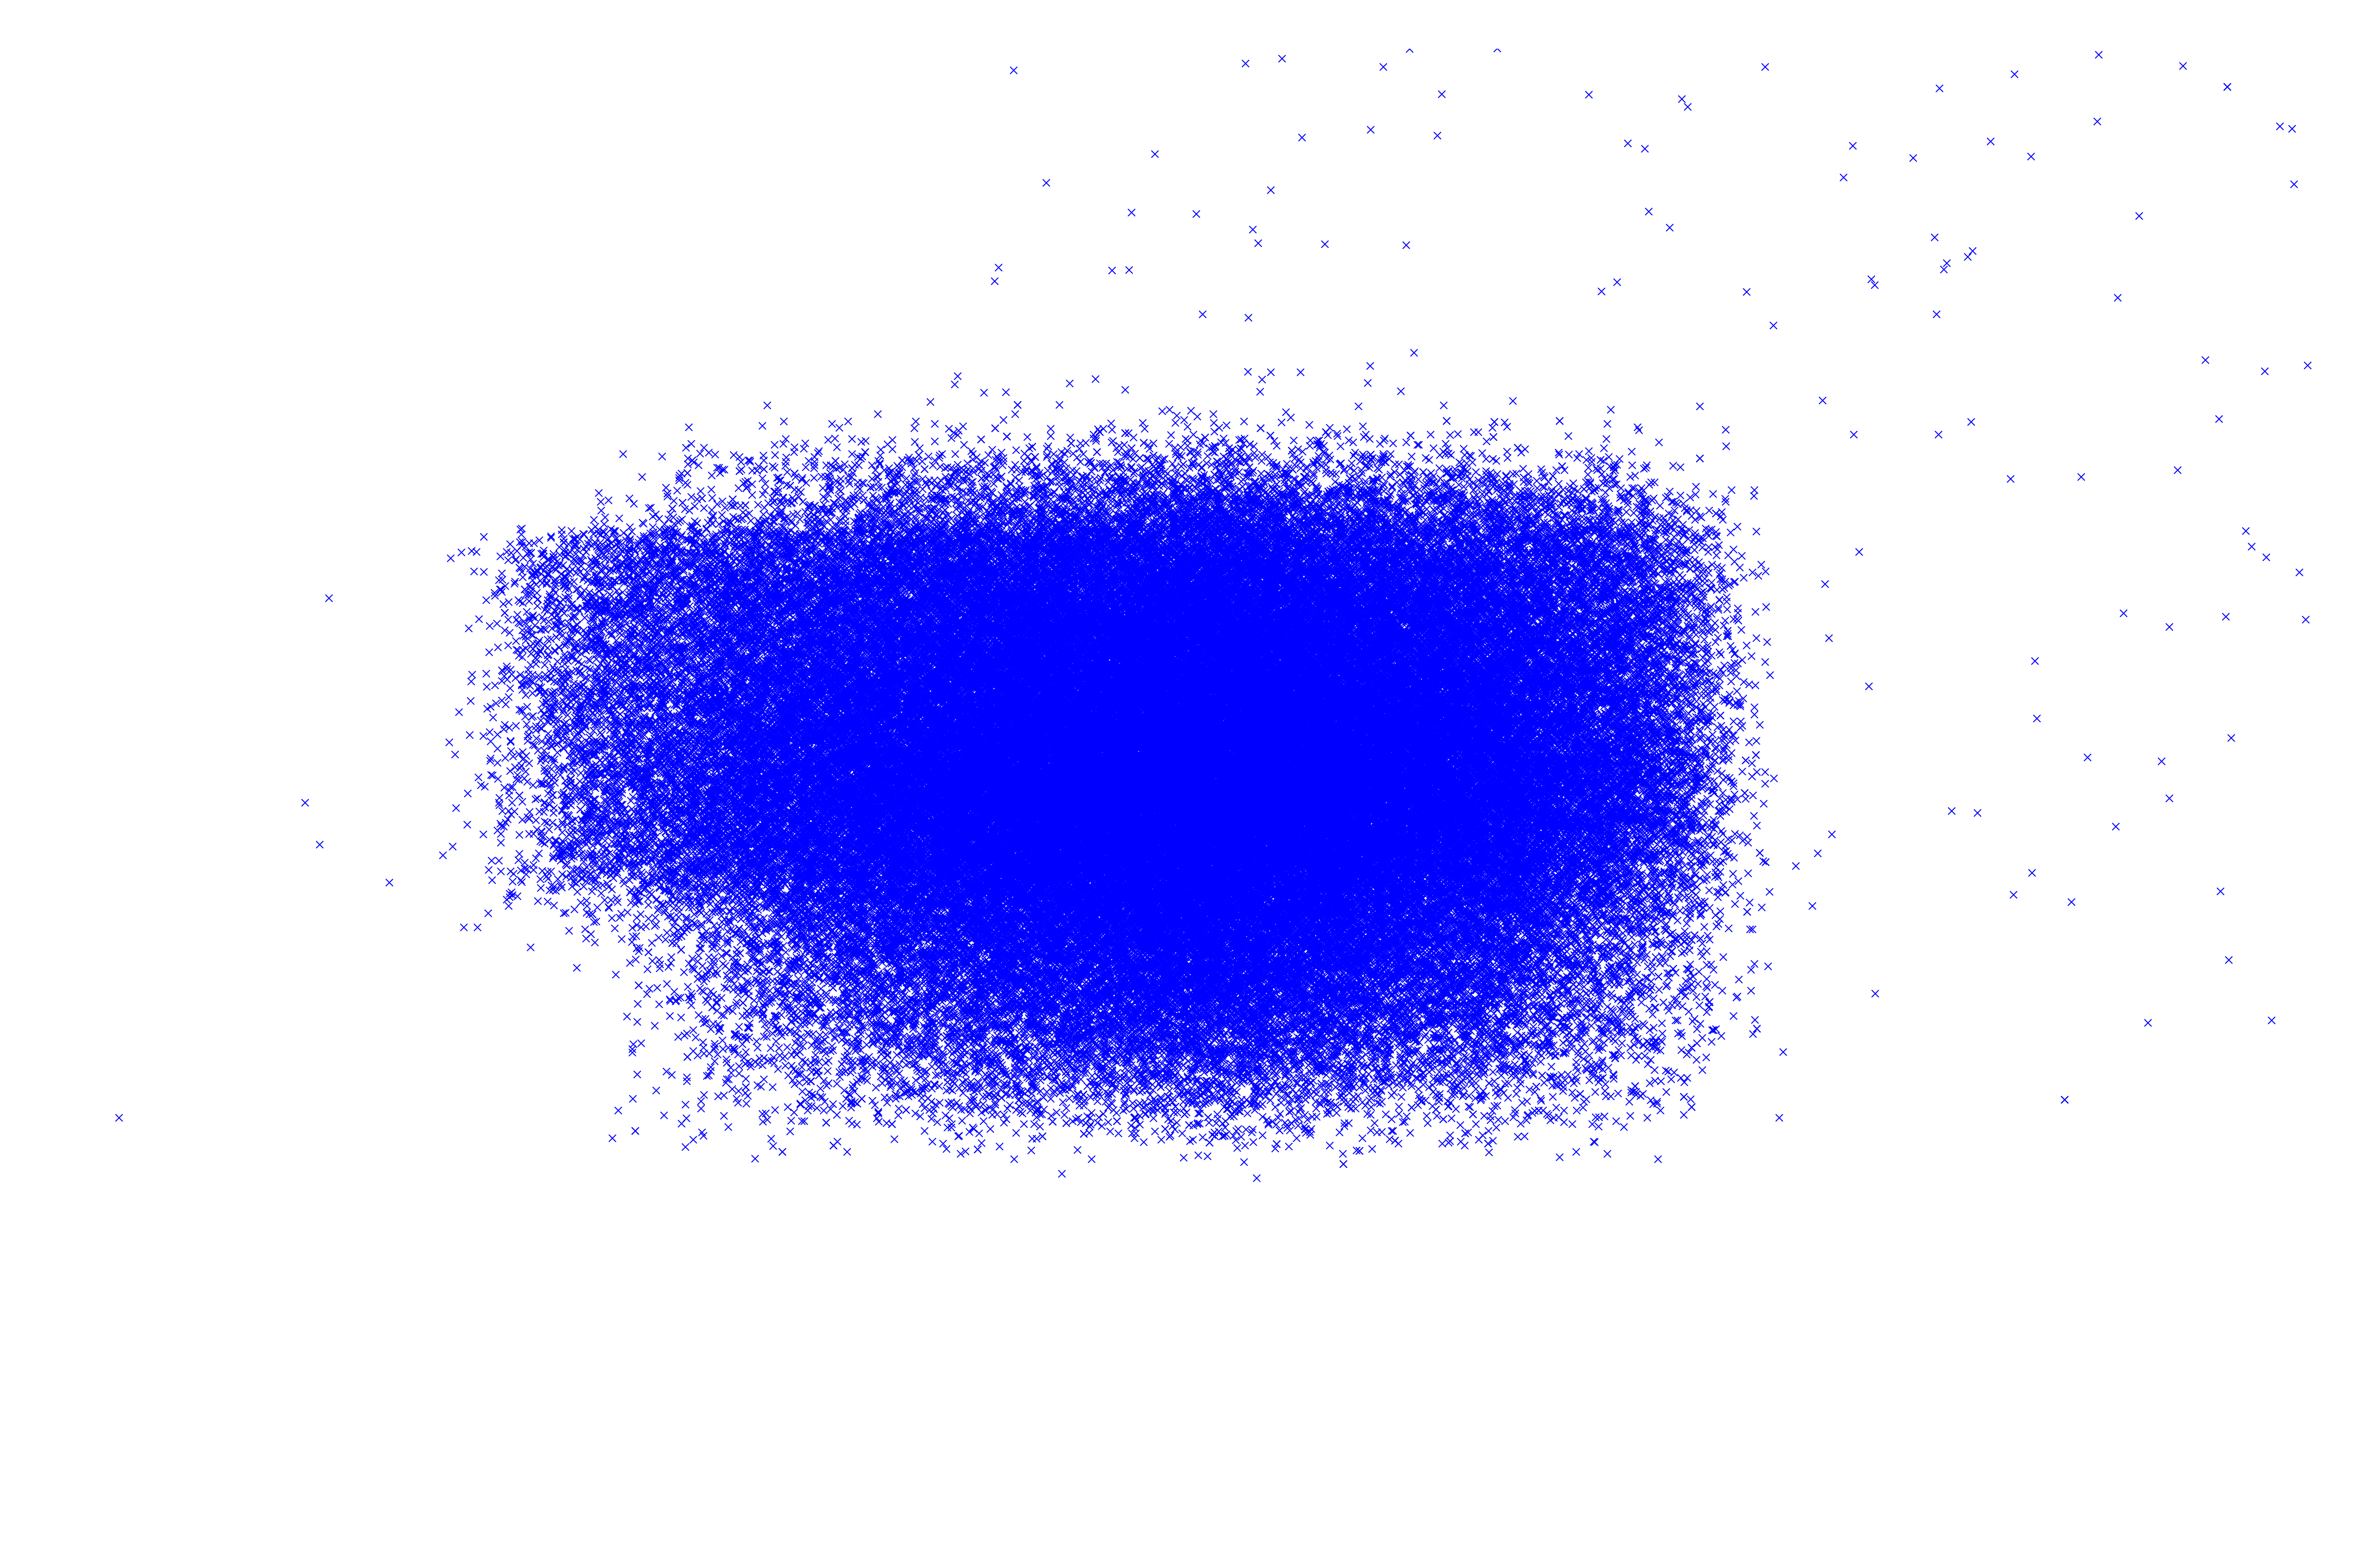

In [8]:

import time

if __name__ == '__main__':
    dir = ""
    start_time = time.time()
    model = TransG(dir, 50, 0.001, 3.5, 4, 0.01)
    model.train(1)
    end_time = time.time()
    # model.test(1)
    model.save()
    model.draw(1000)
    print (end_time - start_time)
    print("OK")